Fit simple models predicting female behavior from surrogate neural activity.

In [3]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge, torch_fit_lin

cc = np.concatenate

NTR = 276
NTRAIN = int(round(.8*NTR))
NSPLIT = 30
NH = 17

ALPHA = 10

FIT_LIN = skl_fit_ridge
FIT_KWARGS = {'alpha': ALPHA}

FPS = 30.03
DT = 1/FPS

# BASIS = 'rect'  # stretched rectangular basis functions
BASIS = 'rc'  # raise cosine

TARG = 'FFV'
# TARG = 'FLS'

PFX_BEHAV = f'data/simple/mlv/lin_filter/{BASIS}_lin/{BASIS}_lin'
SAVE_FILE = f'data/simple/mlv/lin_filter/{BASIS}_lin_{TARG.lower()}_{NTR}_tr.npy'

In [7]:
COLS_USE = [f'S_{ch}' for ch in range(NH)] + [f'P_{ch}' for ch in range(NH)]

# fit regression models
rgrs = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    rnd_tr_idxs = np.random.permutation(NTR)
    idxs_train = rnd_tr_idxs[:NTRAIN]
    idxs_test = rnd_tr_idxs[NTRAIN:]
    rgr = FIT_LIN(PFX_BEHAV, COLS_USE, TARG, idxs_train, idxs_test, **FIT_KWARGS)
    rgrs.append(rgr)

# save r2, weights, and example predictions
save_data = {
    'r2_train': np.array([rgr.r2_train for rgr in rgrs]),
    'r2_test': np.array([rgr.r2_test for rgr in rgrs]),
    'w': np.array([rgr.w for rgr in rgrs]),
    'ys_train': [rgr.ys_train for rgr in rgrs[:2]],
    'y_hats_train': [rgr.y_hats_train for rgr in rgrs[:2]],
    'ys_test': [rgr.ys_test for rgr in rgrs[:2]],
    'y_hats_test': [rgr.y_hats_test for rgr in rgrs[:2]],
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
}

np.save(SAVE_FILE, np.array([save_data]))

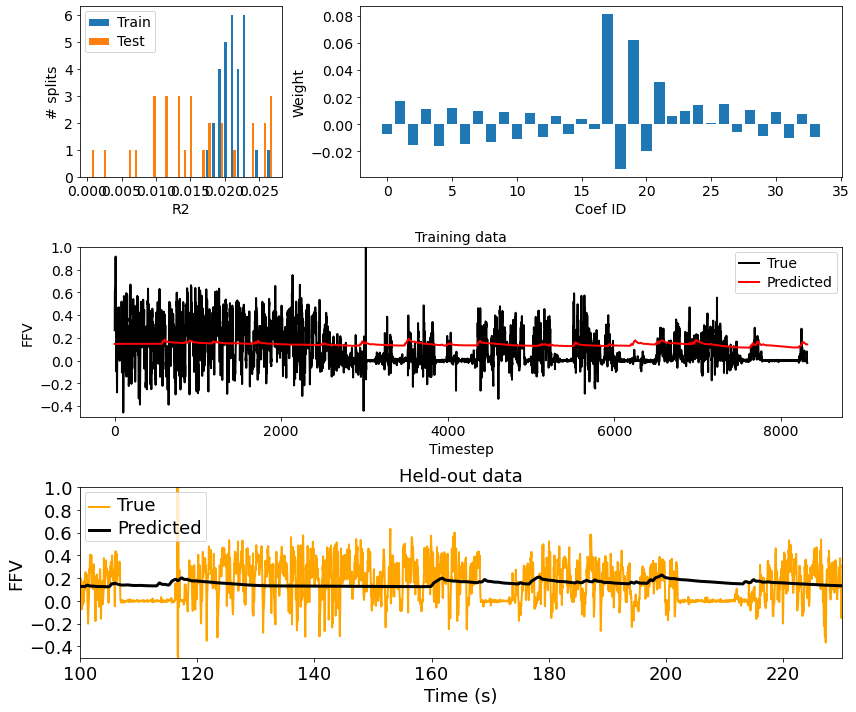

In [4]:
TRAIN_IDX_PLOT = 0
TEST_IDX_PLOT = 0

data = np.load(SAVE_FILE, allow_pickle=True)[0]
gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

axs[0].hist(np.transpose([data['r2_train'], data['r2_test']]), bins=30)
axs[0].legend(['Train', 'Test'])
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

axs[1].bar(np.arange(data['w'].shape[1]), np.mean(data['w'], axis=0))
set_plot(axs[1], x_label='Coef ID', y_label='Weight', font_size=14)

axs[2].plot(np.arange(len(data['ys_train'][0][TRAIN_IDX_PLOT])), data['ys_train'][0][TRAIN_IDX_PLOT], c='k', lw=2)
axs[2].plot(np.arange(len(data['y_hats_train'][0][TRAIN_IDX_PLOT])), data['y_hats_train'][0][TRAIN_IDX_PLOT], c='r', lw=2)
axs[2].legend(['True', 'Predicted'])
set_plot(axs[2], y_lim=(-.5, 1), x_label='Timestep', y_label=TARG, title='Training data', font_size=14)

axs[3].plot(np.arange(len(data['ys_test'][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][0][TEST_IDX_PLOT], c='orange', lw=2)
axs[3].plot(np.arange(len(data['y_hats_test'][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][0][TEST_IDX_PLOT], c='k', lw=3)
axs[3].legend(['True', 'Predicted'], loc='upper left')
set_plot(axs[3], x_lim=(100, 230), y_lim=(-.5, 1), x_label='Time (s)', y_label=TARG, title='Held-out data', font_size=18)

# Show filter reconstructions

In [5]:
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

## Stretched rectangular basis

17 filters


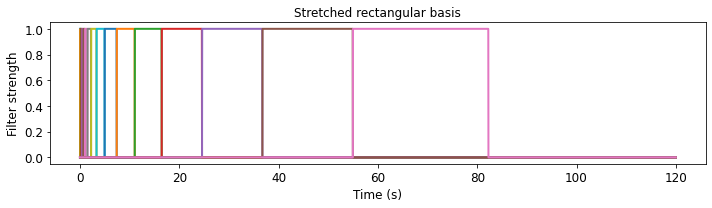

In [6]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

## Raised cosine basis

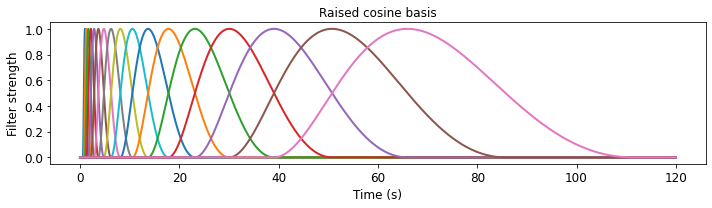

In [7]:
hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

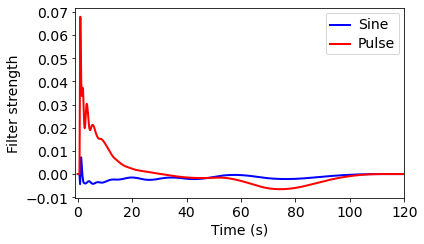

In [9]:
if BASIS == 'rect':
    hs = hs_rect
elif BASIS == 'rc':
    hs = hs_rc
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), tight_layout=True)
# sine filter
w_s = data['w'].mean(0)[:len(hs)]
h_s = w_s@hs

w_p = data['w'].mean(0)[len(hs):]
h_p = w_p@hs

ax.plot(T_H, h_s, c='b', lw=2)
ax.plot(T_H, h_p, c='r', lw=2)

ax.set_xlim(-1, 120)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Filter strength')
ax.legend(['Sine', 'Pulse'])

set_plot(ax, font_size=14)